In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

df = pd.read_csv('crsp_vwretd_1926_2021.csv')

In [2]:
print('HW1')

HW1


In [3]:
print("Team member: Wo Long, Zhiyuan Li")

Team member: Wo Long, Zhiyuan Li


In [4]:
rho = 0.98
sigma_nu = np.sqrt(0.33)
df['vwretd'] = np.log((1 + df['vwretd']))

df.head()

,date,vwretd
0,19260130,0.000561
1,19260227,-0.034182
2,19260331,-0.068431
3,19260430,0.035714
4,19260528,0.011951


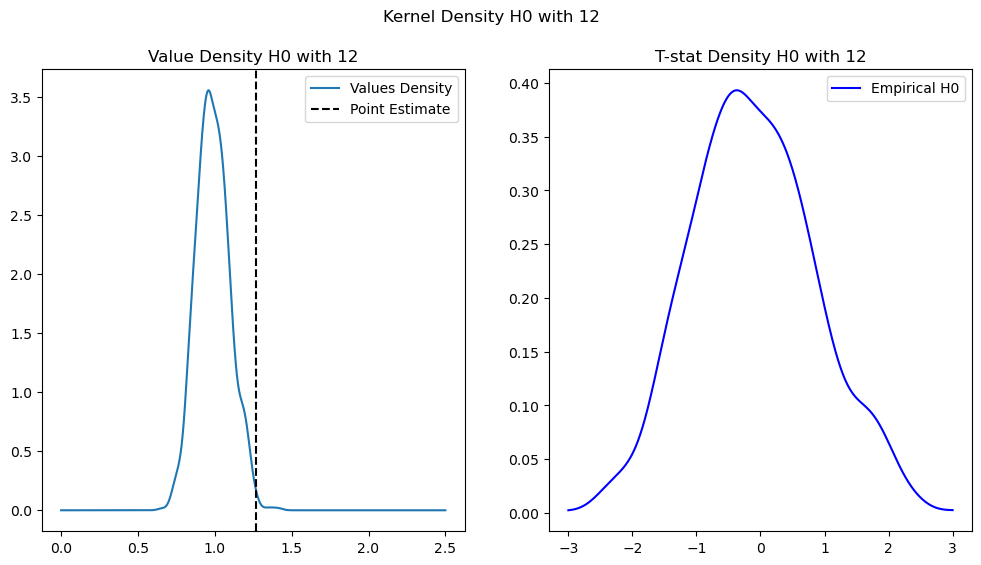

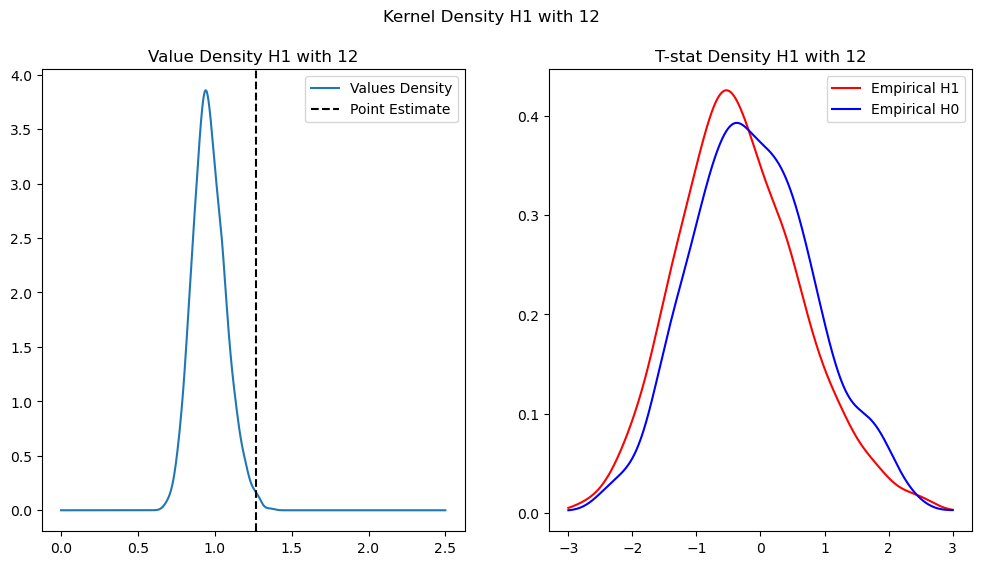

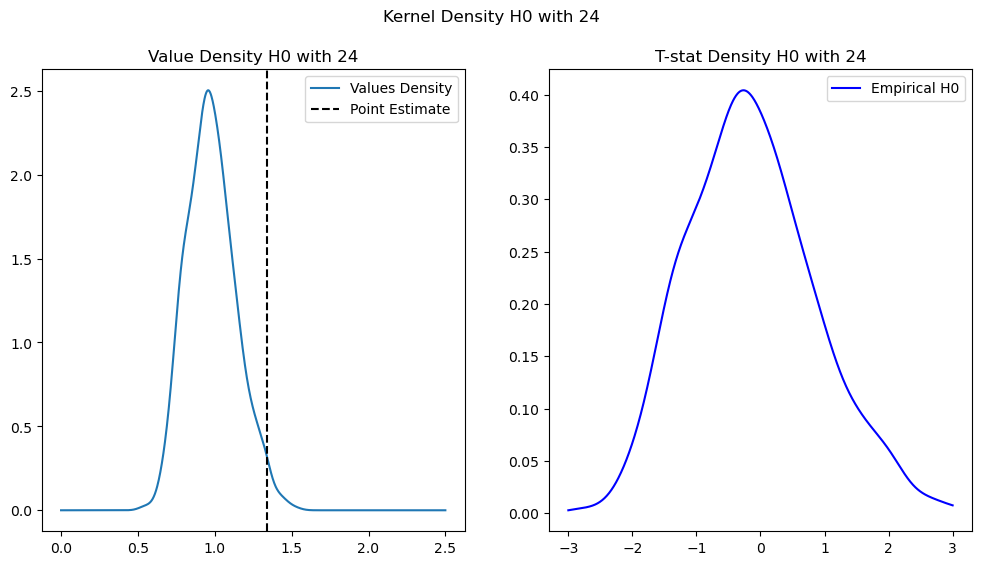

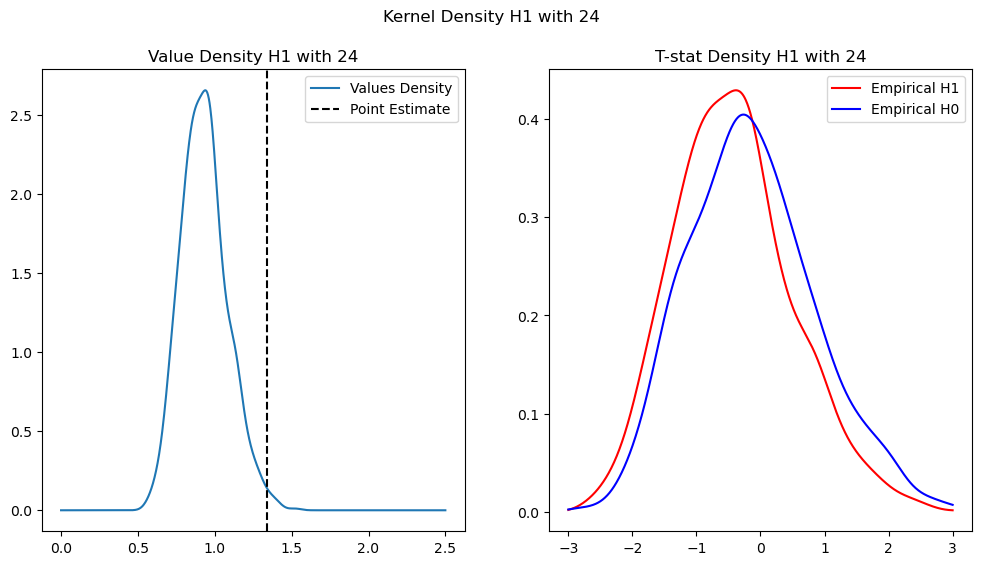

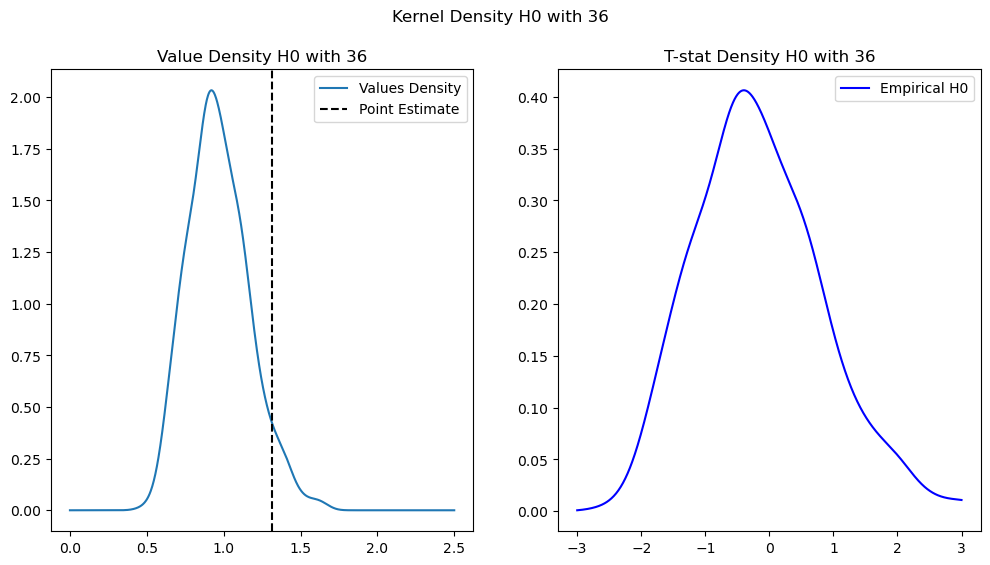

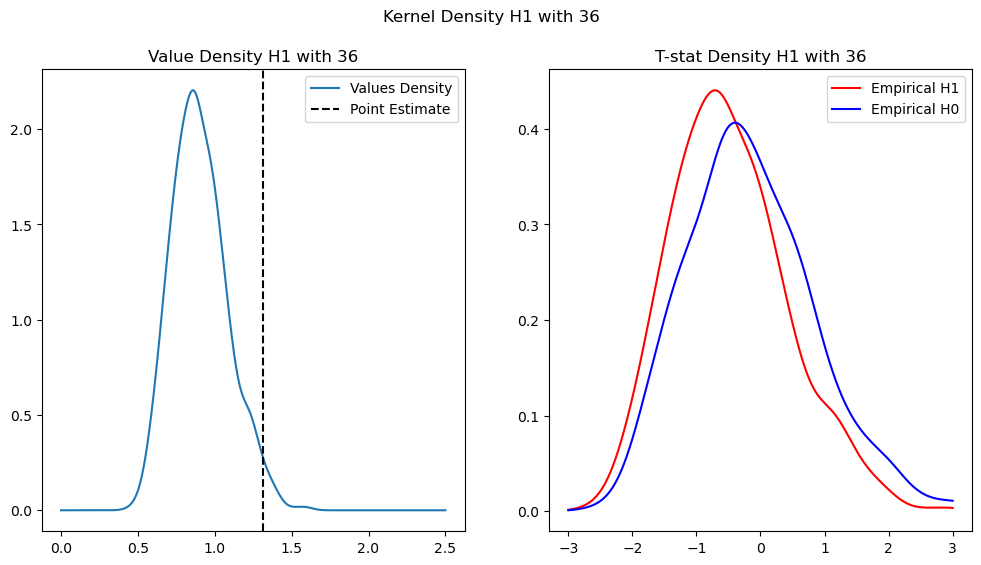

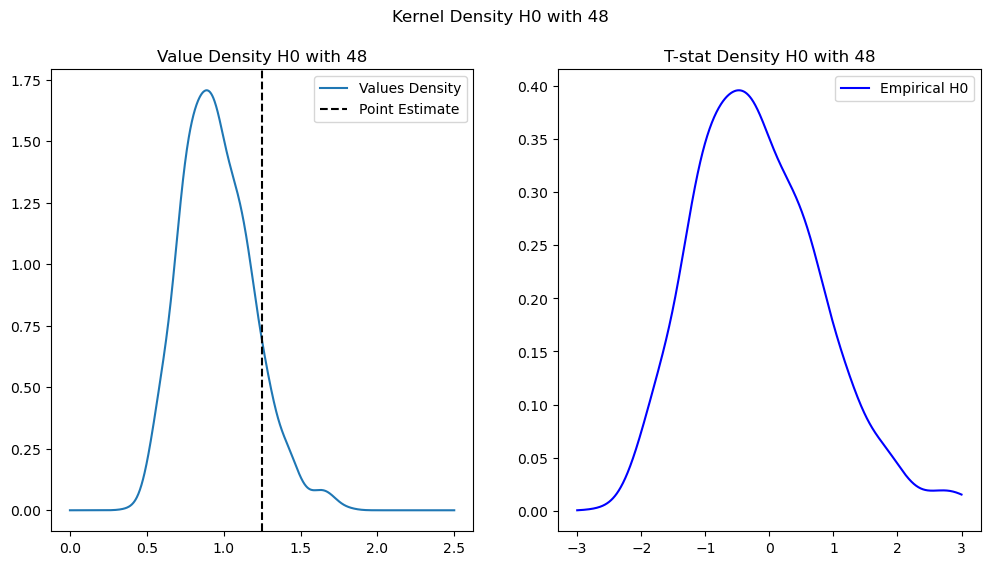

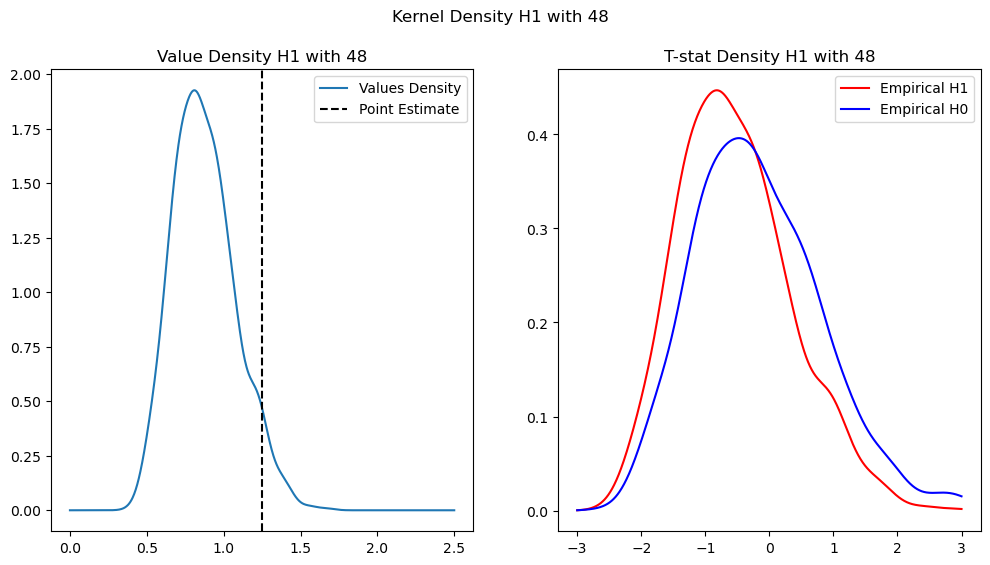

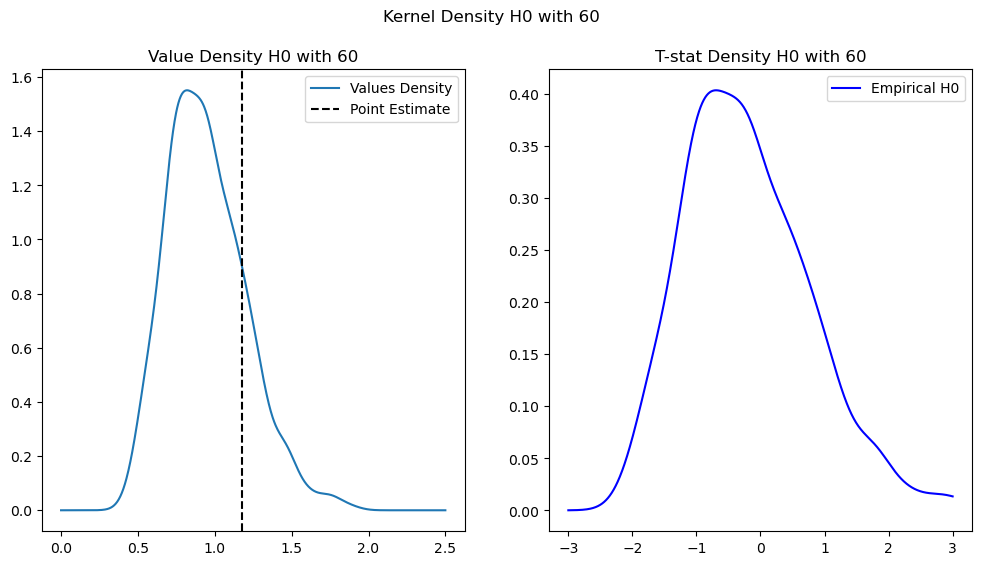

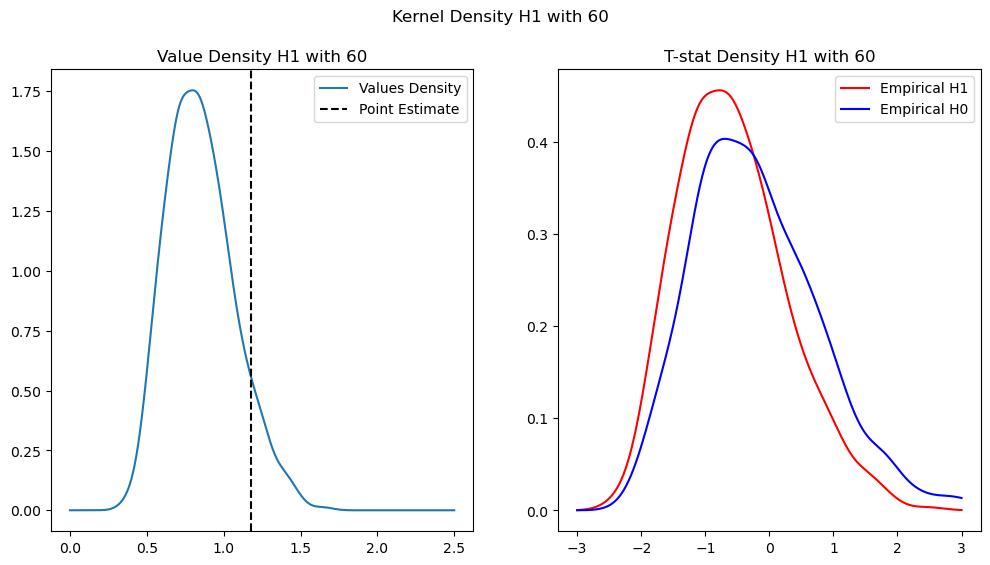

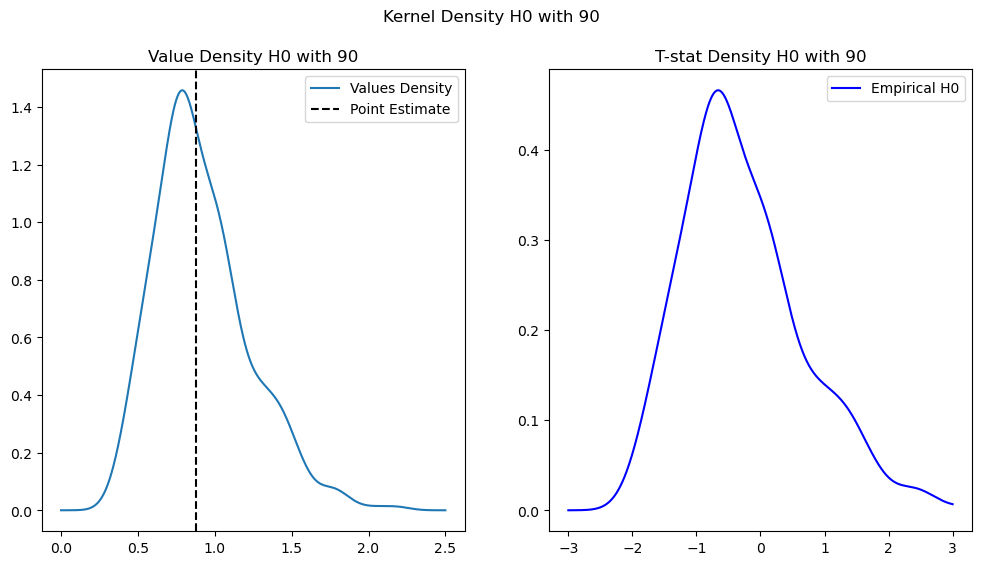

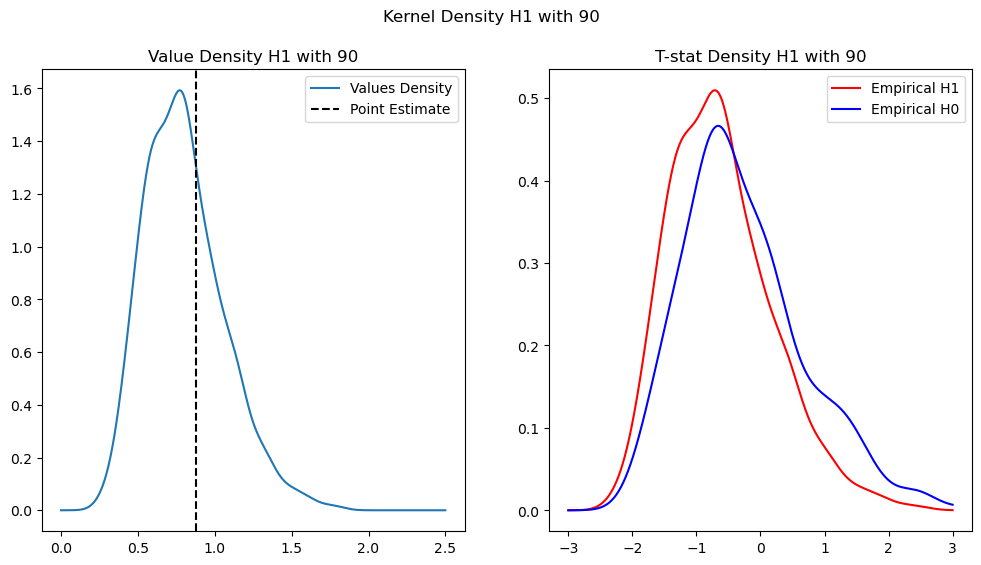

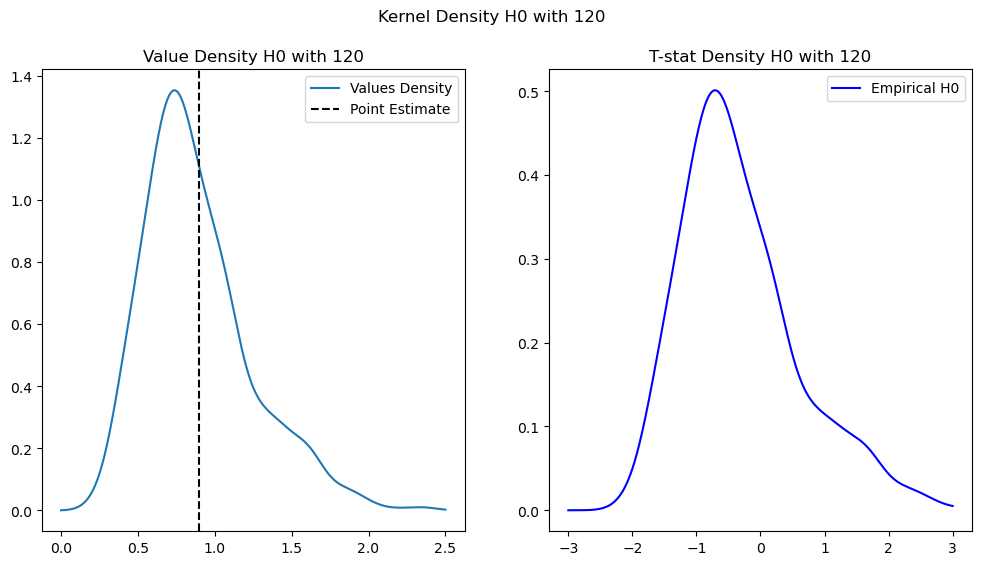

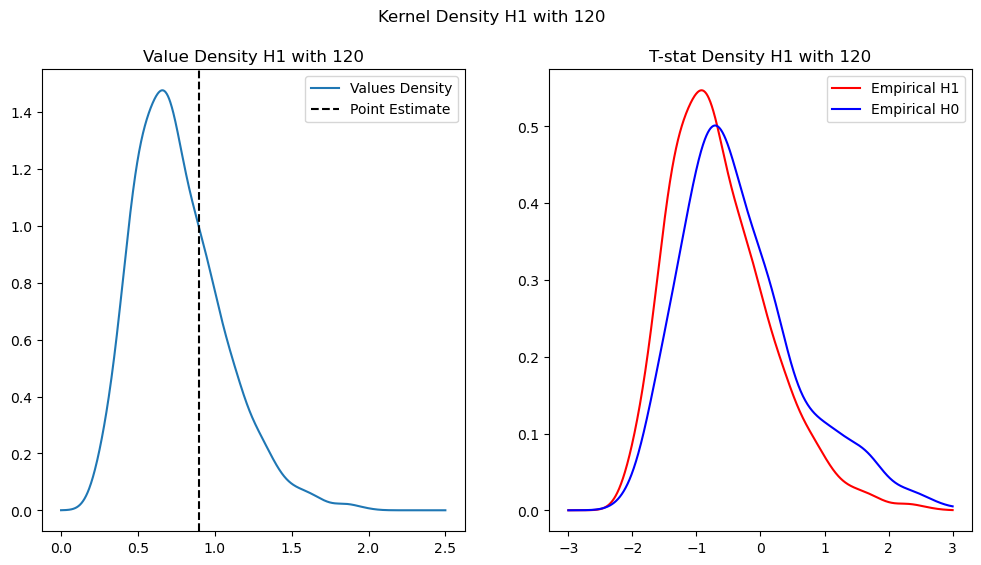

In [7]:
import numpy as np
import pandas as pd
from scipy import stats
import plotly.graph_objects as go
import plotly.subplots as sp

def simulate_returns(N, T, hypothesis):
    if hypothesis == 'H0':
        return np.random.normal(0, 1, size = (N, T))
    
    elif hypothesis == 'H1':
        nu = np.random.normal(0, sigma_nu, size = (N, T + 2))
        eps = np.random.normal(0, 1, size = (N, T + 2))
        u = np.zeros((N, T + 2))

        for t in range(1, T + 2):
            u[:, t] = rho * u[:, t - 1] + nu[:, t]

        return eps[:, 1:T + 1] + u[:, 1:T + 1] - u[:, 0:T]

def calculate_var(df, K):
    df['sum_ret'] = df['vwretd'].rolling(window = K).sum()
    
    return df['sum_ret'].var() / (K * df['vwretd'].var())

def simulate_var(ret, K, N, T, point_est):
    values, t_stats = [], []
    asymp_var = 2 * (2 * K - 1) * (K - 1) / (3 * K * T)

    for i in range(N):
        df = pd.DataFrame({'vwretd': ret[i, :]})
        vr = calculate_var(df, K)
        values.append(vr)
        t_stats.append((vr - 1) / np.sqrt(asymp_var))

    p_value = (np.array(values) < point_est).mean()
    
    return p_value, values, t_stats

def plot_distributions(values, t_stats, point_est, t_stats_H0, hypothesis, K):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    x_values = np.linspace(0, 2.5, 1000)
    x_tstats = np.linspace(-3, 3, 1000)

    axs[0].plot(x_values, stats.gaussian_kde(values)(x_values), label='Values Density')
    axs[0].axvline(x=point_est, color='k', linestyle='--', label='Point Estimate')
    axs[0].set_title(f'Value Density {hypothesis} with {K}')
    axs[0].legend()

    axs[1].plot(x_tstats, stats.gaussian_kde(t_stats)(x_tstats), color='red' if hypothesis == 'H1' else 'blue', label=f'Empirical {hypothesis}')
    if hypothesis == 'H1':
        axs[1].plot(x_tstats, stats.gaussian_kde(t_stats_H0)(x_tstats), color='blue', label='Empirical H0')
    axs[1].set_title(f'T-stat Density {hypothesis} with {K}')
    axs[1].legend()

    plt.suptitle(f'Kernel Density {hypothesis} with {K}')
    plt.show()

N = 1000
T = len(df['vwretd'])

retH0 = simulate_returns(N, T, 'H0')
retH1 = simulate_returns(N, T, 'H1')

VR_df = pd.DataFrame({'K': [12, 24, 36, 48, 60, 90, 120]})

for K in VR_df['K']:
    VR_df.loc[VR_df['K'] == K, 'VR'] = calculate_var(df, K)
    point_est = VR_df.loc[VR_df['K'] == K, 'VR'].iloc[0]

    p_H0, val_H0, t_stat_H0 = simulate_var(retH0, K, N, T, point_est)
    VR_df.loc[VR_df['K'] == K, 'p_H0'] = p_H0

    p_H1, val_H1, t_stat_H1 = simulate_var(retH1, K, N, T, point_est)
    VR_df.loc[VR_df['K'] == K, 'p_H1'] = p_H1

    plot_distributions(val_H0, t_stat_H0, point_est, t_stat_H0, 'H0', K)
    plot_distributions(val_H1, t_stat_H1, point_est, t_stat_H0, 'H1', K)


In [6]:
print(VR_df)

     K        VR   p_H0   p_H1
0   12  1.267482  0.992  0.996
1   24  1.342921  0.981  0.990
2   36  1.314570  0.947  0.975
3   48  1.250165  0.885  0.952
4   60  1.177107  0.811  0.928
5   90  0.876494  0.480  0.653
6  120  0.895637  0.563  0.731
